In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
target = 'ACTION'
IDcol = 'ROLE_CODE'

In [2]:
def load_data(filename, use_labels=True):
    """
    Load data from CSV files and return them as numpy arrays
    The use_labels parameter indicates whether one should
    read the first column (containing class labels). If false,
    return all 0s. 
    """

    # load column 1 to 8 (ignore last one)
    data = np.loadtxt(open("data/" + filename), delimiter=',',
                      usecols=range(1, 9), skiprows=1)
    if use_labels:
        labels = np.loadtxt(open("data/" + filename), delimiter=',',
                            usecols=[0], skiprows=1)
    else:
        labels = np.zeros(data.shape[0])
    return labels, data

def save_results(predictions, filename):
    """Given a vector of predictions, save results in CSV format."""
    with open(filename, 'w') as f:
        f.write("id,ACTION\n")
        for i, pred in enumerate(predictions):
            f.write("%d,%f\n" % (i + 1, pred))


In [14]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print cvresult.shape[0]
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [15]:
train = pd.read_csv('train.csv')

# sz_train = len(train[0])
# train_X = train[:,1:sz_train]
# train_Y = train[:, 0]

predictors = [x for x in train.columns if x not in [target, IDcol]]
# print predictors
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

634

Model Report
Accuracy : 0.9684
AUC Score (Train): 0.983605
CPU times: user 2min 11s, sys: 104 ms, total: 2min 11s
Wall time: 33.2 s


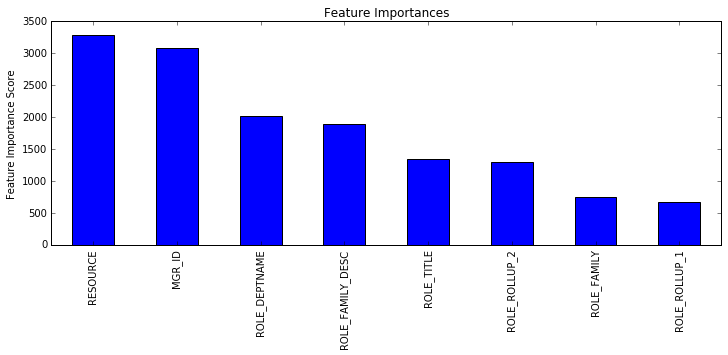

In [16]:
%time modelfit(xgb1, train, predictors)


In [20]:
param_test1 = {
 'max_depth':range(3, 20, 2),
}
param_test1

{'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19]}

In [21]:
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=1, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, cv=5)

In [22]:
%time gsearch1.fit(train[predictors],train[target])

CPU times: user 2min 59s, sys: 130 ms, total: 2min 59s
Wall time: 2min 59s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=140, nthread=1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [23]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.77149, std: 0.01462, params: {'max_depth': 3},
  mean: 0.82336, std: 0.01331, params: {'max_depth': 5},
  mean: 0.84844, std: 0.00785, params: {'max_depth': 7},
  mean: 0.85406, std: 0.01055, params: {'max_depth': 9},
  mean: 0.85933, std: 0.00980, params: {'max_depth': 11},
  mean: 0.86337, std: 0.01034, params: {'max_depth': 13},
  mean: 0.86285, std: 0.00888, params: {'max_depth': 15},
  mean: 0.86451, std: 0.00922, params: {'max_depth': 17},
  mean: 0.86424, std: 0.00815, params: {'max_depth': 19}],
 {'max_depth': 17},
 0.86450894471039663)

In [24]:
param_test2 = {
 'max_depth':[16,17,18],
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=1, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=1,iid=False, cv=5)

In [25]:
%time gsearch2.fit(train[predictors],train[target])

CPU times: user 1min 34s, sys: 74 ms, total: 1min 34s
Wall time: 1min 35s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=140, nthread=1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'max_depth': [16, 17, 18]}, pre_dispatch='2*n_jobs',
       refit=True, scoring='roc_auc', verbose=0)

In [49]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.86353, std: 0.00768, params: {'max_depth': 16},
  mean: 0.86451, std: 0.00922, params: {'max_depth': 17},
  mean: 0.86330, std: 0.00896, params: {'max_depth': 18}],
 {'max_depth': 17},
 0.86450894471039663)

In [26]:
# tune 'colsample_bytree'
param_test3 = {'colsample_bytree':[i/10.0 for i in range(6,10)]}

In [27]:
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=1, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=1,iid=False, cv=5)

In [28]:
gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=140, nthread=1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [30]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.82187, std: 0.01235, params: {'colsample_bytree': 0.6},
  mean: 0.82380, std: 0.01258, params: {'colsample_bytree': 0.7},
  mean: 0.82336, std: 0.01331, params: {'colsample_bytree': 0.8},
  mean: 0.82378, std: 0.01207, params: {'colsample_bytree': 0.9}],
 {'colsample_bytree': 0.7},
 0.82379560898042536)

In [33]:
param_test4 = {'colsample_bytree':[0.7,0.75]}

In [34]:
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=1, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=1,iid=False, cv=5)

In [35]:
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=140, nthread=1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'colsample_bytree': [0.7, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [36]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch3.best_score_

([mean: 0.82380, std: 0.01258, params: {'colsample_bytree': 0.7},
  mean: 0.82336, std: 0.01331, params: {'colsample_bytree': 0.75}],
 {'colsample_bytree': 0.7},
 0.82379560898042536)

634

Model Report
Accuracy : 0.9764
AUC Score (Train): 0.996021


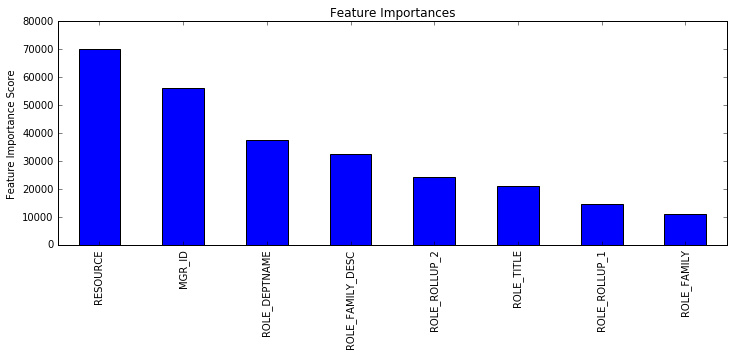

In [37]:
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=634,
 max_depth=17,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.7,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

In [48]:
test = pd.read_csv('test.csv')
idtest = test[u'id'].values

In [49]:
#Fit the algorithm on the data
xgb2.fit(train[predictors], train[target],eval_metric='auc')
        
#Predict test set:
test_predictions = xgb2.predict(test[predictors])
test_predprob = xgb2.predict_proba(test[predictors])[:,1]

In [50]:
submission = pd.DataFrame({"id":idtest, "ACTION":test_predprob})
submission = submission[['id', 'ACTION']]
submission.to_csv("xgb_submission.csv", index=False)